In [1]:
# Loan Approval Prediction using Random Forest Classifier

# 1.Problem Statement
# Predicting whether a loan application will be approved or not based on applicant information.

# 2. Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
#3. Data Loading
train = pd.read_csv('/content/train_u6lujuX_CVtuZ9i.csv')
print(f"Dataset Shape: {train.shape}")
train.head()

Dataset Shape: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


/tmp/ipython-input-6-2033580318.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train, x='Loan_Status', palette='Set2')


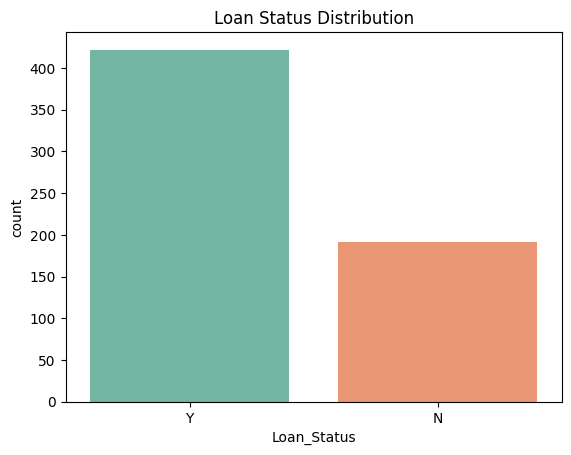

Loan_Status
Y    0.687296
N    0.312704
Name: proportion, dtype: float64


In [6]:
#4. EDA: Target Variable Distribution
sns.countplot(data=train, x='Loan_Status', palette='Set2')
plt.title('Loan Status Distribution')
plt.show()
print(train['Loan_Status'].value_counts(normalize=True))

In [7]:
# 5. Missing Values
print(train.isnull().sum())

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [ ]:
#6. Data Cleaning
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']:
    train[col].fillna(train[col].mode()[0], inplace=True)
train['LoanAmount'].fillna(train['LoanAmount'].median(), inplace=True)
train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0], inplace=True)

In [9]:
# Drop Loan_ID
train.drop('Loan_ID', axis=1, inplace=True)

In [10]:
# 7. Feature Engineering
train['Total_Income'] = train['ApplicantIncome'] + train['CoapplicantIncome']
train['Loan_Income_Ratio'] = train['LoanAmount'] / (train['Total_Income'] + 1)
train['EMI'] = train['LoanAmount'] / (train['Loan_Amount_Term'] + 1)
train['Income_Per_Person'] = train['Total_Income'] / (train['Dependents'].replace('3+', 3).astype(int) + 1)

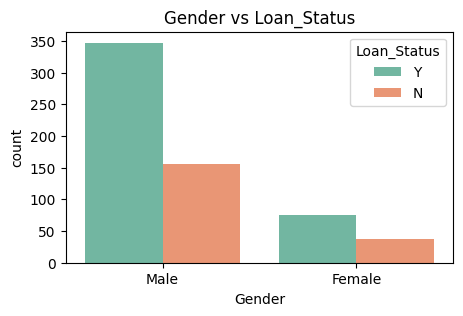

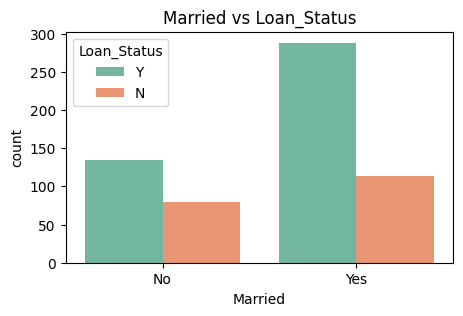

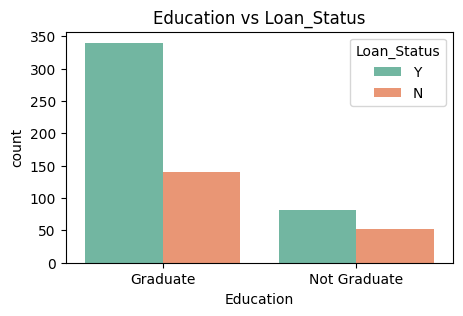

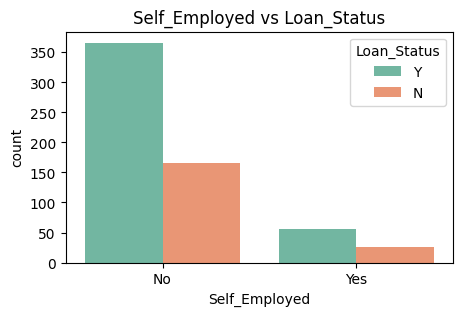

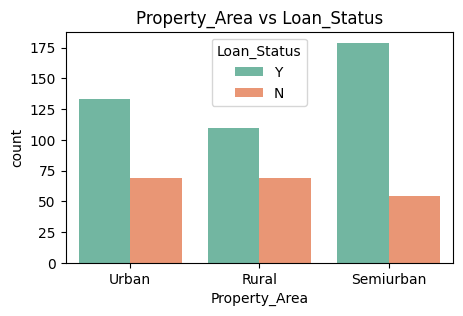

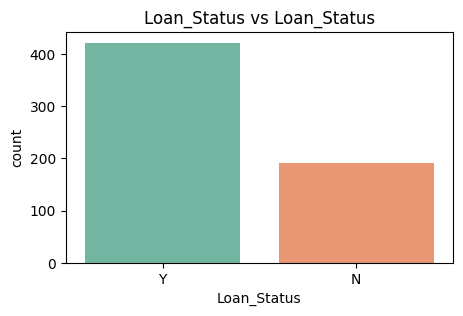

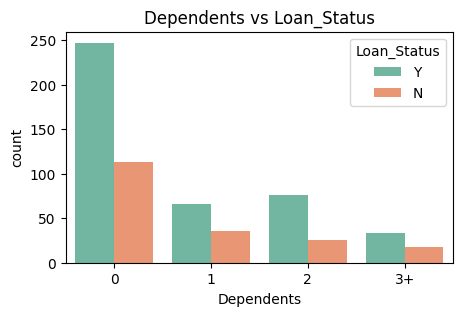

In [11]:
# 8. EDA: Categorical Analysis
cat_cols = ['Gender','Married','Education','Self_Employed','Property_Area','Loan_Status','Dependents']
for col in cat_cols:
    plt.figure(figsize=(5,3))
    sns.countplot(data=train, x=col, hue='Loan_Status',palette='Set2')
    plt.title(f'{col} vs Loan_Status')
    plt.show()

In [12]:
#9. Label Encoding
le = LabelEncoder()
for col in cat_cols:
    train[col] = le.fit_transform(train[col])

In [13]:
# 10. Feature-Target Split
X = train.drop('Loan_Status', axis=1)
y = train['Loan_Status']

In [14]:
# 11. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
# 12. Random Forest Classifier with Cross Validation
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring='accuracy')
print(f"\nCross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("\nDefault Random Forest Classifier Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



Cross-Validation Accuracy Scores: [0.81818182 0.67346939 0.80612245 0.71428571 0.81632653]
Mean CV Accuracy: 0.7657

Default Random Forest Classifier Performance:
Accuracy: 0.8536585365853658
Confusion Matrix:
 [[26 12]
 [ 6 79]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.68      0.74        38
           1       0.87      0.93      0.90        85

    accuracy                           0.85       123
   macro avg       0.84      0.81      0.82       123
weighted avg       0.85      0.85      0.85       123



In [16]:
# 13. Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    scoring='accuracy'
)
grid_search.fit(X_train, y_train)

print("\nBest Hyperparameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_


Best Hyperparameters: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [17]:
# 14. Final Model Evaluation
y_pred_best = best_rf.predict(X_test)
print("\nTuned Random Forest Classifier Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))


Tuned Random Forest Classifier Performance:
Accuracy: 0.8292682926829268
Confusion Matrix:
 [[28 10]
 [11 74]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.74      0.73        38
           1       0.88      0.87      0.88        85

    accuracy                           0.83       123
   macro avg       0.80      0.80      0.80       123
weighted avg       0.83      0.83      0.83       123



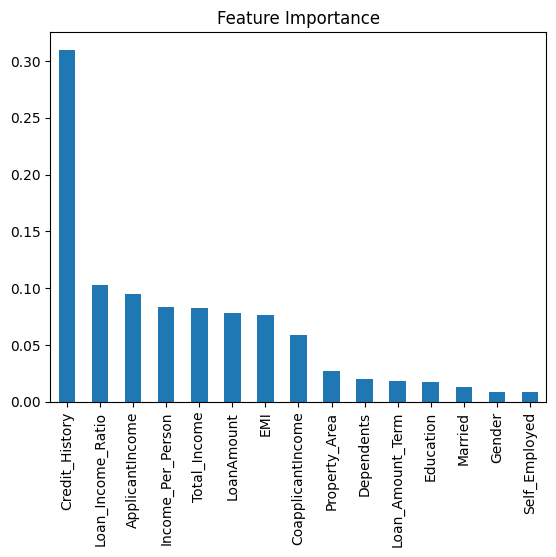

In [19]:
# 15. Feature Importance
feat_imp = pd.Series(best_rf.feature_importances_, index=X.columns)
feat_imp.sort_values(ascending=False).plot(kind='bar', title='Feature Importance')
plt.show()